# Predicting Gene Sequence Regenerative Contributions 

By: Jaeyoon Jung, Jeremy Milford, Shree Patel, Cynthia Perez

This notebook develops a model from one hot encoded gene sequences of the axolotl, norwegian rat, and zebrafish. This notebook uses one hot encoded and Fourier transformed data to build a CNN with an attention component. The model is further optimized with GridSearch. 

### Necessary Imports

In [1]:
# necessary imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Reshape, Conv1D, Layer, MaxPooling1D, Flatten, Input, Attention, Flatten, TimeDistributed
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from onehot import onehote
import torch

2024-12-12 12:48:54.930224: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.config.threading.set_intra_op_parallelism_threads(2)  
# tf.config.threading.set_inter_op_parallelism_threads(2)
# tf.config.set_visible_devices([], 'GPU')

In [3]:
features_df = pd.read_csv("gene_sequences.csv")
features_df.head()

,gene_name,sequence_length,gc_content,at_gc_ratio,kmer_3_GGG,kmer_3_GGC,kmer_3_GCG,kmer_3_CGG,kmer_3_GCT,kmer_3_CTG,...,kmer_3_TAG,kmer_3_CAN,kmer_3_ANN,kmer_3_NNN,kmer_3_NNT,kmer_3_NTA,organism,chromosome,regen,sequence
0,ADIPOQ,1487,0.465367,1.148844,0.014141,0.016162,0.005387,0.005387,0.013468,0.022896,...,0.008754,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CTCAGGAGACCTGGCGATTTTCTCTTCATTCCTGTCTGTACGAGTG...
1,AGTR1A,2286,0.463255,1.158640,0.007881,0.018827,0.005692,0.004378,0.022329,0.029335,...,0.007881,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CCGAGCCTGAGGGTTGGAACCTGCAGAGCAGCGACGCCCCCTAGGC...
2,AGTR2,2861,0.386928,1.584463,0.008395,0.010843,0.001399,0.001749,0.015390,0.023435,...,0.011193,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CCAGAGTCTGGGGATGGAGCGAGCACAGAATTGAAAGCTTTCTTCA...
3,AMTN,1032,0.465116,1.150000,0.011650,0.013592,0.001942,0.001942,0.014563,0.025243,...,0.005825,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,X2,1,AAAAGATAAATTTTGCACCAGAGTAAAGTGGAGAAGTCATCTGGAT...
4,ARHGDIA,89866,0.470211,1.126704,0.016681,0.013810,0.006310,0.007344,0.015112,0.021421,...,0.011440,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,3q,0,TTTCTAGAGCTCTCTTGTGGGACGGGAACTAGATAGACCGGAACTA...


### Test, Train Split

In [4]:
# Drop gene_name and separate features and target 
X = features_df.drop(columns=['gene_name'])
y = (features_df['regen']).astype(int)  
y = y.to_numpy()

# Choose only numeric features for modeling
X_col = X.columns
print(X_col)
X_numeric_features = ["sequence_length", "gc_content", "at_gc_ratio", 'kmer_3_GGG',
       'kmer_3_GGC', 'kmer_3_GCG', 'kmer_3_CGG', 'kmer_3_GCT', 'kmer_3_CTG',
       'kmer_3_TGC', 'kmer_3_GCC', 'kmer_3_CCG', 'kmer_3_CGC', 'kmer_3_CCA',
       'kmer_3_CAG', 'kmer_3_AGC', 'kmer_3_CCC', 'kmer_3_CTA', 'kmer_3_TAA',
       'kmer_3_AAG', 'kmer_3_AGG', 'kmer_3_CTC', 'kmer_3_TCG', 'kmer_3_GGA',
       'kmer_3_GAG', 'kmer_3_AGA', 'kmer_3_TCT', 'kmer_3_TGT', 'kmer_3_GTT',
       'kmer_3_TTT', 'kmer_3_TTC', 'kmer_3_TCC', 'kmer_3_AGT', 'kmer_3_GTC',
       'kmer_3_GTG', 'kmer_3_TGG', 'kmer_3_CTT', 'kmer_3_TTA', 'kmer_3_AAA',
       'kmer_3_CAC', 'kmer_3_ACT', 'kmer_3_CGT', 'kmer_3_CAA', 'kmer_3_AAT',
       'kmer_3_ATG', 'kmer_3_TAT', 'kmer_3_TGA', 'kmer_3_GAC', 'kmer_3_ACA',
       'kmer_3_TCA', 'kmer_3_CCT', 'kmer_3_ACG', 'kmer_3_GAT', 'kmer_3_ATC',
       'kmer_3_CGA', 'kmer_3_CAT', 'kmer_3_TAC', 'kmer_3_AAC', 'kmer_3_GCA',
       'kmer_3_GAA', 'kmer_3_ACC', 'kmer_3_GGT', 'kmer_3_ATT', 'kmer_3_TTG',
       'kmer_3_ATA', 'kmer_3_GTA', 'kmer_3_TAG', 'kmer_3_CAN', 'kmer_3_ANN',
       'kmer_3_NNN', 'kmer_3_NNT', 'kmer_3_NTA']

X = X.drop(columns = X_numeric_features)
X.head()

Index(['sequence_length', 'gc_content', 'at_gc_ratio', 'kmer_3_GGG',
       'kmer_3_GGC', 'kmer_3_GCG', 'kmer_3_CGG', 'kmer_3_GCT', 'kmer_3_CTG',
       'kmer_3_TGC', 'kmer_3_GCC', 'kmer_3_CCG', 'kmer_3_CGC', 'kmer_3_CCA',
       'kmer_3_CAG', 'kmer_3_AGC', 'kmer_3_CCC', 'kmer_3_CTA', 'kmer_3_TAA',
       'kmer_3_AAG', 'kmer_3_AGG', 'kmer_3_CTC', 'kmer_3_TCG', 'kmer_3_GGA',
       'kmer_3_GAG', 'kmer_3_AGA', 'kmer_3_TCT', 'kmer_3_TGT', 'kmer_3_GTT',
       'kmer_3_TTT', 'kmer_3_TTC', 'kmer_3_TCC', 'kmer_3_AGT', 'kmer_3_GTC',
       'kmer_3_GTG', 'kmer_3_TGG', 'kmer_3_CTT', 'kmer_3_TTA', 'kmer_3_AAA',
       'kmer_3_CAC', 'kmer_3_ACT', 'kmer_3_CGT', 'kmer_3_CAA', 'kmer_3_AAT',
       'kmer_3_ATG', 'kmer_3_TAT', 'kmer_3_TGA', 'kmer_3_GAC', 'kmer_3_ACA',
       'kmer_3_TCA', 'kmer_3_CCT', 'kmer_3_ACG', 'kmer_3_GAT', 'kmer_3_ATC',
       'kmer_3_CGA', 'kmer_3_CAT', 'kmer_3_TAC', 'kmer_3_AAC', 'kmer_3_GCA',
       'kmer_3_GAA', 'kmer_3_ACC', 'kmer_3_GGT', 'kmer_3_ATT', 'kmer_3_TTG',
       

,organism,chromosome,regen,sequence
0,Rattus norvegicus,2,0,CTCAGGAGACCTGGCGATTTTCTCTTCATTCCTGTCTGTACGAGTG...
1,Rattus norvegicus,2,0,CCGAGCCTGAGGGTTGGAACCTGCAGAGCAGCGACGCCCCCTAGGC...
2,Rattus norvegicus,2,0,CCAGAGTCTGGGGATGGAGCGAGCACAGAATTGAAAGCTTTCTTCA...
3,Rattus norvegicus,X2,1,AAAAGATAAATTTTGCACCAGAGTAAAGTGGAGAAGTCATCTGGAT...
4,Ambystoma mexicanum,3q,0,TTTCTAGAGCTCTCTTGTGGGACGGGAACTAGATAGACCGGAACTA...


In [5]:
# one hot encode each sequence and store in a NumPy array
# determine longest sequence
max_len = 25000

print(f"Max sequence length: {max_len}")

sequences_ohe = []
updated_Y = [] 
for i, seq in enumerate(X['sequence']):
    output = onehote(seq)
    if output is None:
        continue
    else:
        sequences_ohe.append(output)
        updated_Y.append(y[i]) 
        
sequences_X_padded = pad_sequences(sequences_ohe, padding='post', maxlen = max_len, dtype='float32', value=0)
# Replace the original Y_train with the updated one
Y = np.array(updated_Y)

Max sequence length: 25000
Skipping long sequence of length 89866
Skipping long sequence of length 397239
Skipping long sequence of length 941704
Skipping long sequence of length 421024
Skipping long sequence of length 185889
Skipping long sequence of length 30544
Skipping long sequence of length 97743
Skipping long sequence of length 1868600
Skipping long sequence of length 343410
Skipping long sequence of length 297582
Skipping long sequence of length 80286
Skipping long sequence of length 38674
Skipping long sequence of length 340476
Skipping long sequence of length 929300
Skipping long sequence of length 193940
Skipping long sequence of length 800864
Skipping long sequence of length 281266
Skipping long sequence of length 38671
Skipping long sequence of length 203183
Skipping long sequence of length 679286
Skipping long sequence of length 230816
Skipping long sequence of length 181724
Skipping long sequence of length 338667
Skipping long sequence of length 234099
Skipping long sequ

In [6]:
# fourier transform 

def apply_fourier_transform(padded_sequences):
    """
    Apply Fourier Transform along the sequence length for each channel.
    """
    # Perform Fourier Transform along the sequence length axis (axis=-1)
    fft_result = tf.signal.fft(padded_sequences)  

    magnitude_spectrum = tf.abs(fft_result) 
    return magnitude_spectrum

spectrum = apply_fourier_transform(sequences_X_padded)

num_frequencies = 50  # Retain only top 50 frequencies
reduced_spectrum = spectrum[:, :, :num_frequencies]

In [7]:
scaler = MinMaxScaler()

# Apply MinMaxScaler along the axes
normalized_spectrum = np.array([
    scaler.fit_transform(sample) for sample in reduced_spectrum
])

# train, test split
X_train, X_test, Y_train, Y_test = train_test_split(normalized_spectrum, Y, test_size=0.2, random_state=46)
print(len(X_train))

# Assuming Y_train contains your labels
class_0_count = np.sum(Y_train == 0)
class_1_count = np.sum(Y_train == 1)

# Set the weight to 1 for the majority class (class 0) and higher for the minority class (class 1)
class_weights = {0: (len(Y_train)) / class_0_count, 1: len(Y_train) / class_1_count}  # Inverse of class frequency

# If you want to manually adjust the weight of the minority class, you can use any ratio like this:
# class_weights = {0: 1.0, 1: 5.0}  # Example where the minority class (class 1) is weighted 5 times more

print("Class weights:", class_weights)

print(np.sum(Y_test == 0))
print(len(Y_test))

80
Class weights: {0: 2.0, 1: 2.0}
8
20


This train, test split has considered the sequences of the genes and has no additional information on the chromosome, organism, etc.

### CNN with Attention Mechanism

In [9]:
# Input layer
batch = 4
input_shape = (max_len, 4)  
input_layer = Input(shape=input_shape)

# Feature extraction
x = Conv1D(filters=32, kernel_size=3, kernel_regularizer=l2(0.01), activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Apply Attention 
query = Dense(32)(x)  # Generate query (adjust??)
value = Dense(32)(x)  # Generate value (same size as query)
key = Dense(32)(x)    # Generate key (same size as query)

x = Attention()([query, value, key])

# Flatten the time and bin dimensions for dense layers
x = Flatten()(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Model creation
model = Model(inputs=input_layer, outputs=output_layer)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    X_train, Y_train,
    epochs=50,                 # Maximum number of epochs
    batch_size= batch,
    validation_data = (X_test, Y_test),
    class_weight = class_weights,
    callbacks=[early_stopping])  # Add the EarlyStopping callback here

# Summary
model.summary()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3776 - loss: 8.1215 - val_accuracy: 0.6000 - val_loss: 6.1703
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4977 - loss: 8.3085 - val_accuracy: 0.4000 - val_loss: 5.2765
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4709 - loss: 5.6423 - val_accuracy: 0.3500 - val_loss: 4.1679
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5357 - loss: 4.7847 - val_accuracy: 0.4500 - val_loss: 3.2914
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4870 - loss: 3.8849 - val_accuracy: 0.4000 - val_loss: 2.9587
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4910 - loss: 3.3502 - val_accuracy: 0.5500 - val_loss: 2.3306
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4614 - loss: 3.0201 - val_accuracy: 0.4500 - val_loss: 2.1866
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4793 - loss: 2.8974 - val_accuracy: 0.4000 - val_loss:

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 25000, 4)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24998, 32) │        416 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 12499, 32) │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 12499, 32) │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 12497,     │     12,416 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 6248, 128) │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 6248, 128) │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 6248, 32)  │      4,128 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 6248, 32)  │      4,128 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 6248, 32)  │      4,128 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 6248, 32)  │          0 │ dense_6[0][0],    │
│ (Attention)         │                   │            │ dense_7[0][0],    │
│                     │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 199936)    │          0 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │ 25,591,936 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 76,876,421 (293.26 MB)

 Trainable params: 25,625,473 (97.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,250,948 (195.51 MB)

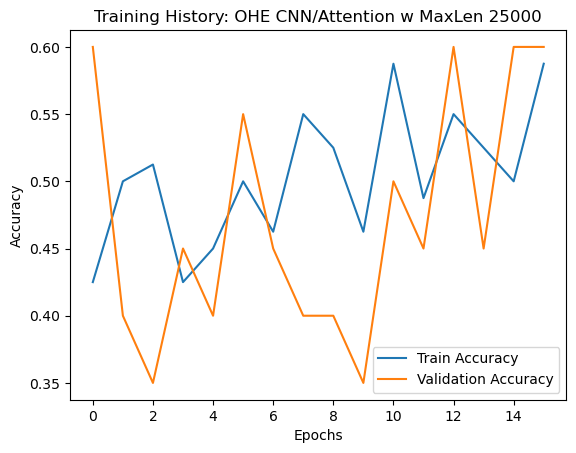

In [10]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History: OHE CNN/Attention w MaxLen 25000")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


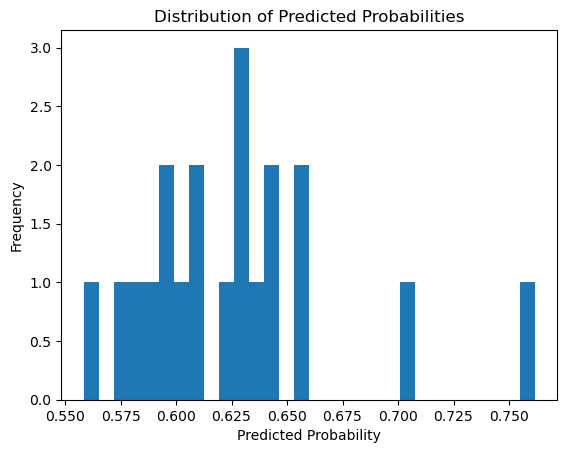

Predicted probabilities: [[0.6398716 ]
 [0.65795505]
 [0.6236199 ]
 [0.6328714 ]
 [0.55849606]
 [0.59647685]
 [0.70203006]
 [0.5951163 ]
 [0.5911641 ]
 [0.6265632 ]]


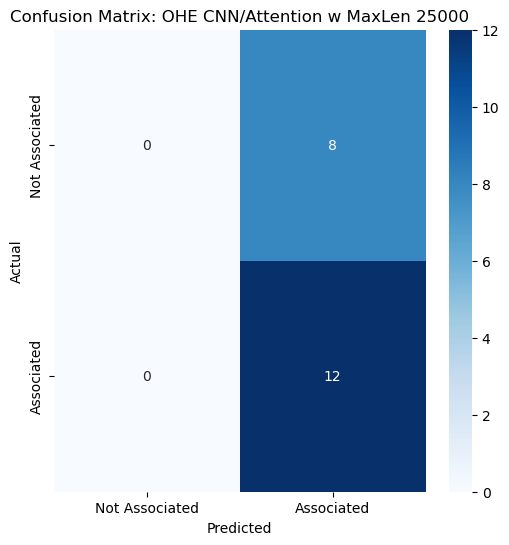

                precision    recall  f1-score   support

Not Associated       0.00      0.00      0.00         8
    Associated       0.60      1.00      0.75        12

      accuracy                           0.60        20
     macro avg       0.30      0.50      0.38        20
  weighted avg       0.36      0.60      0.45        20

Test Accuracy: 0.6


/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

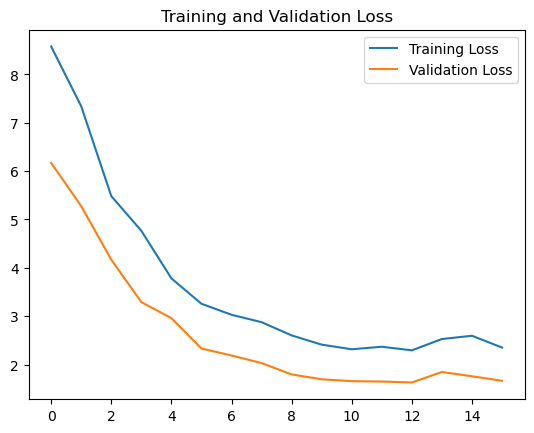

In [13]:
# this model has no test set, so disregard this cell

y_pred = model.predict(X_test)

# Plot the predicted probabilities
plt.hist(y_pred, bins=30)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

print("Predicted probabilities:", y_pred[:10])  # Check the first 10 predictions

threshold = 0.5  # Adjust the threshold value as needed
y_pred_binary = (y_pred >= threshold).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.title("Confusion Matrix: OHE CNN/Attention w MaxLen 25000")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_binary, target_names=["Not Associated", "Associated"]))

print("Test Accuracy:", accuracy_score(Y_test, y_pred_binary))

# Plot loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()